# Ekstraksi Kata Kunci dengan Word Graph dan Analisis Sentralitas

Notebook ini melakukan ekstraksi kata kunci dari dokumen PDF menggunakan metode word graph dan berbagai pengukuran sentralitas (PageRank, Degree Centrality, Betweenness Centrality, dan Closeness Centrality).

In [61]:
%pip install pymupdf nltk networkx pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


## 1. Instalasi Paket yang Diperlukan

Menginstal semua library Python yang dibutuhkan untuk:
- **pymupdf**: Ekstraksi teks dari file PDF
- **nltk**: Natural Language Processing (tokenisasi, stopwords)
- **networkx**: Pembuatan dan analisis graf
- **pandas**: Manipulasi data
- **numpy**: Operasi numerik
- **matplotlib**: Visualisasi graf

## 2. Ekstraksi Teks dari PDF

Mengekstrak seluruh teks dari file PDF dan menyimpannya ke dalam file `output.txt`. Setiap halaman dipisahkan dengan karakter form feed.

In [62]:
# Ekstraksi teks dari PDF
import pymupdf

# Path absolut ke file PDF (sesuaikan jika foldernya berbeda)
pdf_path = r"D:\Tugas Semester 7\PPWeb\UAS\Dampak-Investasi-Cryptocurrency.pdf"

# Buka file PDF
doc = pymupdf.open(pdf_path)
# Buat file output untuk menyimpan teks
out = open("output.txt", "wb")

# Loop setiap halaman dalam dokumen
for page in doc:
    text = page.get_text().encode("utf8")  # Ambil teks dari halaman
    out.write(text)  # Tulis teks ke file
    out.write(bytes((12,)))  # Tulis pemisah halaman (form feed)
out.close()
print("Ekstraksi PDF selesai.")

Ekstraksi PDF selesai.


## 3. Download Resource NLTK

Mengunduh resource yang dibutuhkan untuk Natural Language Processing:
- **punkt**: Tokenizer untuk memisahkan teks menjadi kalimat
- **stopwords**: Daftar kata-kata umum yang tidak bermakna (stop words)

In [63]:
# Download resource NLTK
import nltk
nltk.download('punkt')  # Untuk tokenisasi kalimat
nltk.download('punkt_tab')  # Versi terbaru tokenizer
nltk.download('stopwords')  # Daftar stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 4. Tokenisasi Teks Menjadi Kalimat

Membaca file teks yang telah diekstrak, kemudian memecahnya menjadi kalimat-kalimat individual dan menyimpannya dalam file CSV.

In [64]:
# Baca dan tokenisasi teks menjadi kalimat
import pandas as pd

# Baca file teks hasil ekstraksi PDF
with open('output.txt', 'r', encoding='utf-8') as file:
    teks = file.read()

# Pisahkan teks menjadi kalimat-kalimat
sentences = nltk.sent_tokenize(teks)
# Simpan kalimat ke dalam DataFrame
df = pd.DataFrame(sentences, columns=['kalimat'])
# Simpan ke file CSV
df.to_csv('kalimat.csv', index=False, encoding='utf-8')
print(f"Total kalimat: {len(sentences)}")

Total kalimat: 300


## 5. Pembuatan Matriks Ko-okurensi dengan Unigram dan Bigram

Proses ini melakukan:
1. **Preprocessing teks**: Membersihkan teks dari angka, karakter khusus, dan stopwords
2. **Ekstraksi unigram**: Kata tunggal yang bermakna
3. **Ekstraksi bigram**: Gabungan 2 kata berurutan
4. **Matriks ko-okurensi**: Menghitung kemunculan bersama antar kata dalam jendela tertentu

In [65]:
# Membangun matriks ko-okurensi dengan unigram dan bigram
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict, Counter
import numpy as np
import re

# Baca file CSV kalimat
df = pd.read_csv("kalimat.csv")
# Gabungkan semua kalimat menjadi satu teks
text = " ".join(df.iloc[:,0].astype(str))

# Preprocessing teks: hapus angka dan karakter khusus
stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
words = word_tokenize(text.lower())  # Tokenisasi dan ubah ke huruf kecil

# Filter: hanya kata alfabetik, tanpa angka, tanpa karakter tunggal, bukan stopwords
unigrams = [word for word in words if word.isalpha() and len(word) > 1 and word not in stop_words]

# Generasi bigram (gabungan 2 kata)
bigrams_raw = list(ngrams(unigrams, 2))
bigrams_formatted = [f"{word1} {word2}" for word1, word2 in bigrams_raw]

# Gabungkan unigram dan bigram
processed_terms = unigrams + bigrams_formatted

# Tentukan ukuran jendela untuk ko-okurensi
window_size = 2

# Buat struktur ko-okurensi awal berbasis jendela
co_occurrences = defaultdict(Counter)
for i, term in enumerate(processed_terms):
    # Untuk setiap term, cek term di sekitarnya dalam jendela
    for j in range(max(0, i - window_size), min(len(processed_terms), i + window_size + 1)):
        if i != j:
            co_occurrences[term][processed_terms[j]] += 1

# Tambahkan hubungan eksplisit antara bigram dan dua unigram penyusunnya
for (word1, word2), bigram in zip(bigrams_raw, bigrams_formatted):
    # Bigram terhubung ke kedua kata pembentuknya
    co_occurrences[bigram][word1] += 1
    co_occurrences[bigram][word2] += 1
    co_occurrences[word1][bigram] += 1
    co_occurrences[word2][bigram] += 1

# Dapatkan list term unik
unique_terms = list(set(processed_terms))
# Inisialisasi matriks ko-okurensi
co_matrix = np.zeros((len(unique_terms), len(unique_terms)), dtype=int)

# Isi matriks dengan nilai ko-okurensi
term_index = {term: idx for idx, term in enumerate(unique_terms)}
for term, neighbors in co_occurrences.items():
    for neighbor, count in neighbors.items():
        co_matrix[term_index[term]][term_index[neighbor]] = count

# Buat DataFrame dari matriks
co_matrix_df = pd.DataFrame(co_matrix, index=unique_terms, columns=unique_terms)
print(f"Matriks ko-okurensi dibuat: {co_matrix_df.shape}")
print(f"Total term unik (unigram + bigram): {len(unique_terms)}")

Matriks ko-okurensi dibuat: (2817, 2817)
Total term unik (unigram + bigram): 2817


## 5.1. Visualisasi Matriks Ko-okurensi

Menampilkan matriks ko-okurensi dalam bentuk heatmap. Karena matriks sangat besar (2817x2817), kita akan menampilkan:
1. **Heatmap untuk top 50 kata** berdasarkan frekuensi kemunculan
2. **Tabel sebagian kecil matriks** untuk melihat detail nilai ko-okurensi


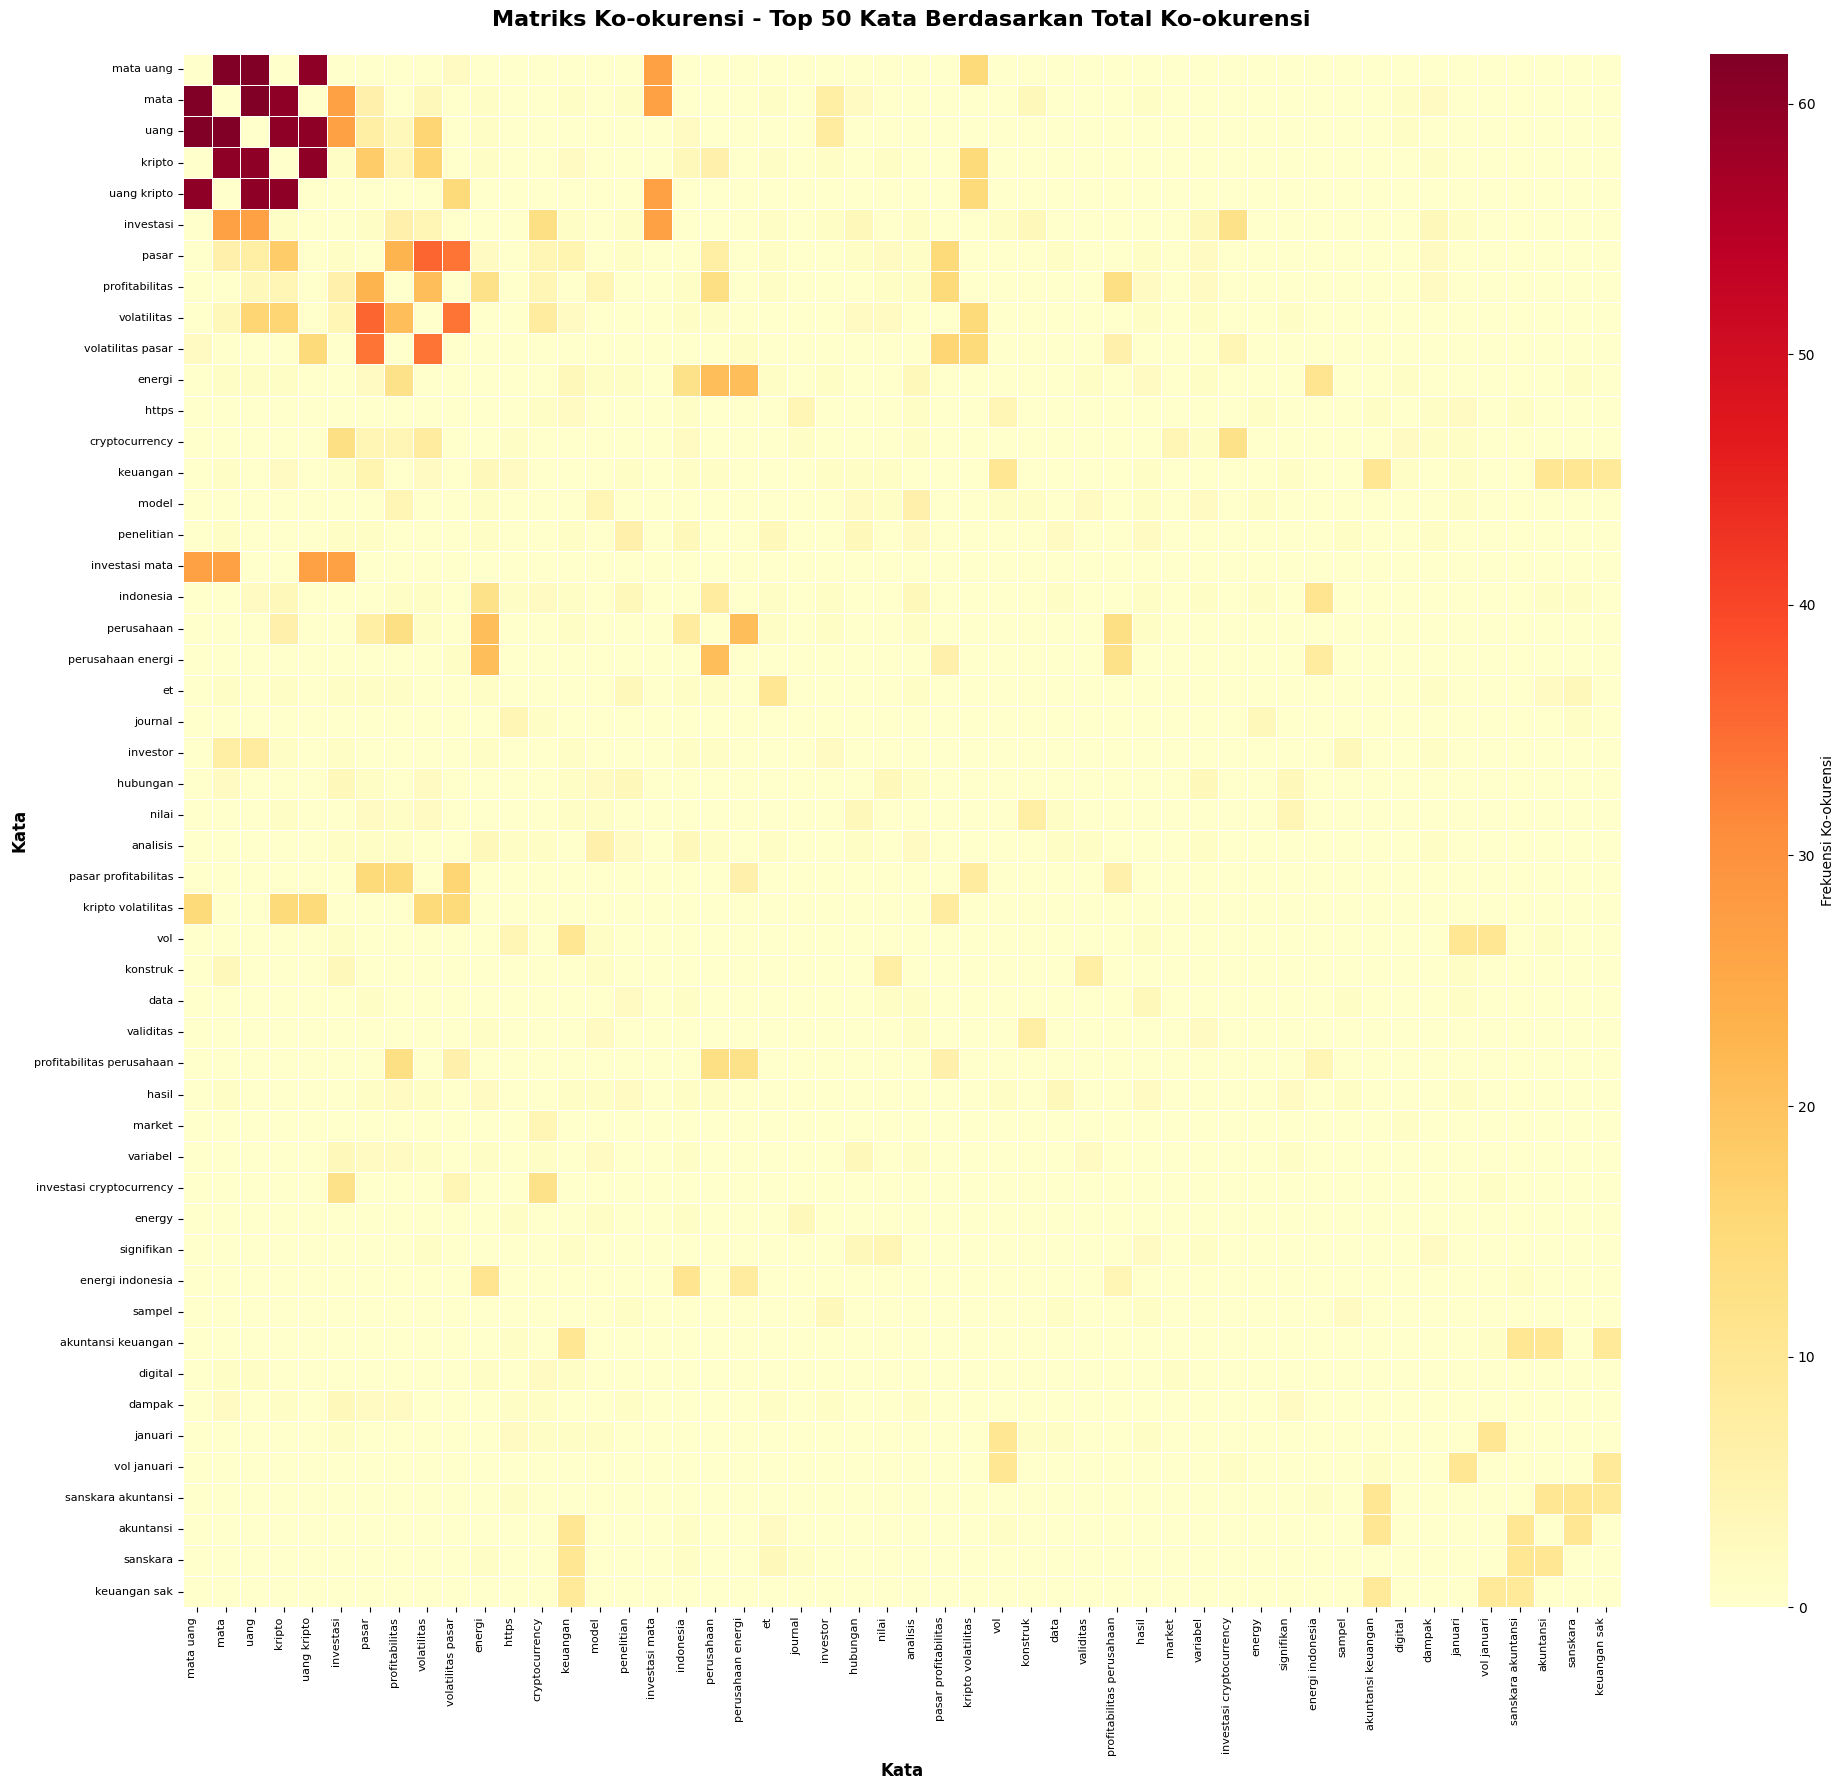


Matriks subset untuk top 50 kata: (50, 50)
Total ko-okurensi tertinggi: 372


In [66]:
# Visualisasi Matriks Ko-okurensi - Heatmap untuk Top 50 Kata
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung total ko-okurensi untuk setiap kata (jumlah baris)
word_totals = co_matrix_df.sum(axis=1).sort_values(ascending=False)

# Ambil top 50 kata berdasarkan total ko-okurensi
top_50_words = word_totals.head(50).index.tolist()

# Ambil submatriks untuk top 50 kata
co_matrix_subset = co_matrix_df.loc[top_50_words, top_50_words]

# Buat heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(co_matrix_subset, 
            annot=False,  # Tidak menampilkan angka karena terlalu padat
            cmap='YlOrRd', 
            fmt='d',
            cbar_kws={'label': 'Frekuensi Ko-okurensi'},
            xticklabels=True,
            yticklabels=True,
            linewidths=0.5)

plt.title('Matriks Ko-okurensi - Top 50 Kata Berdasarkan Total Ko-okurensi', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Kata', fontsize=12, fontweight='bold')
plt.ylabel('Kata', fontsize=12, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

print(f"\nMatriks subset untuk top 50 kata: {co_matrix_subset.shape}")
print(f"Total ko-okurensi tertinggi: {word_totals.iloc[0]:.0f}")


In [67]:
# Tampilkan sebagian kecil matriks ko-okurensi sebagai tabel (top 20 kata)
top_20_words = word_totals.head(20).index.tolist()
co_matrix_sample = co_matrix_df.loc[top_20_words, top_20_words]

print("="*80)
print("MATRIKS KO-OKURENSI - Top 20 Kata (Tampilan Tabel)")
print("="*80)
print(f"\nUkuran matriks: {co_matrix_sample.shape}")
print(f"\nNilai dalam matriks menunjukkan frekuensi kemunculan bersama antara dua kata.")
print(f"Semakin tinggi nilainya, semakin sering kedua kata muncul bersamaan dalam jendela yang sama.\n")

# Tampilkan matriks sebagai tabel
print(co_matrix_sample.to_string())
print("\n" + "="*80)


MATRIKS KO-OKURENSI - Top 20 Kata (Tampilan Tabel)

Ukuran matriks: (20, 20)

Nilai dalam matriks menunjukkan frekuensi kemunculan bersama antara dua kata.
Semakin tinggi nilainya, semakin sering kedua kata muncul bersamaan dalam jendela yang sama.

                   mata uang  mata  uang  kripto  uang kripto  investasi  pasar  profitabilitas  volatilitas  volatilitas pasar  energi  https  cryptocurrency  keuangan  model  penelitian  investasi mata  indonesia  perusahaan  perusahaan energi
mata uang                  0    62    62       0           60          0      0               0            0                  2       0      0               0         0      0           0              27          0           0                  0
mata                      62     0    62      60            0         27      6               0            3                  0       1      0               0         1      0           1              27          0           0                  0
uang        

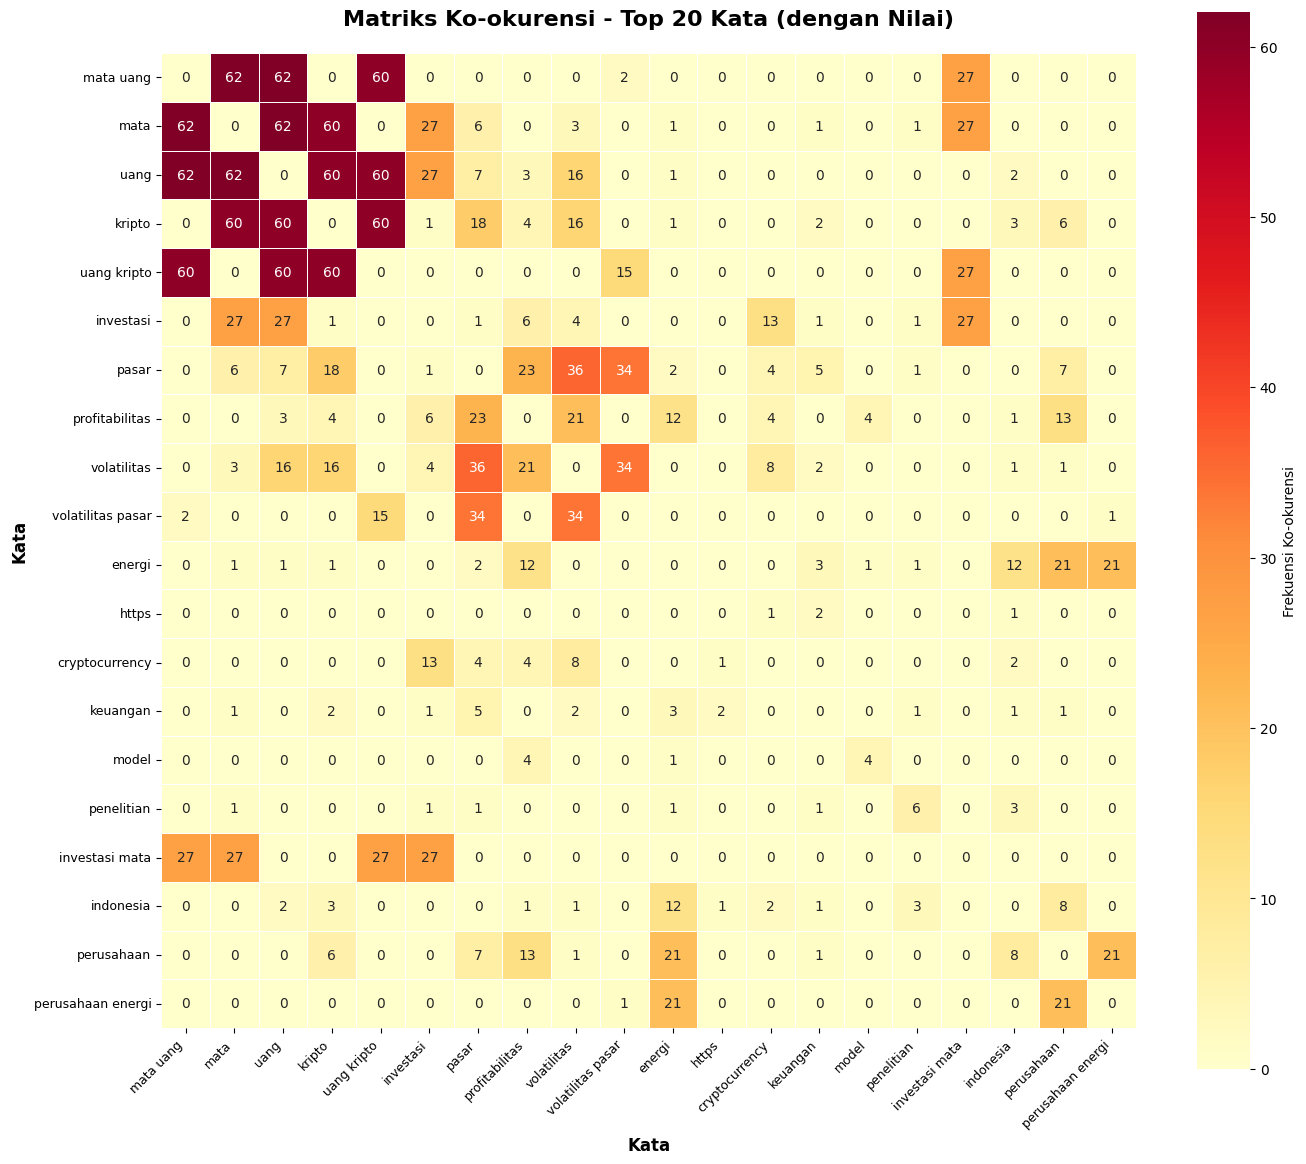


Catatan: Nilai diagonal biasanya tinggi karena kata terhubung dengan dirinya sendiri melalui bigram.


In [68]:
# Visualisasi Heatmap dengan Annotasi untuk Top 20 Kata (lebih detail)
plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix_sample, 
            annot=True,  # Tampilkan angka
            cmap='YlOrRd', 
            fmt='d',  # Format integer
            cbar_kws={'label': 'Frekuensi Ko-okurensi'},
            xticklabels=True,
            yticklabels=True,
            linewidths=0.5,
            square=True)

plt.title('Matriks Ko-okurensi - Top 20 Kata (dengan Nilai)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Kata', fontsize=12, fontweight='bold')
plt.ylabel('Kata', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print("\nCatatan: Nilai diagonal biasanya tinggi karena kata terhubung dengan dirinya sendiri melalui bigram.")


In [69]:
# Buat graf dari matriks ko-okurensi
import networkx as nx

# Konversi matriks adjacency menjadi graf NetworkX
G = nx.from_pandas_adjacency(co_matrix_df)
print(f"Graf dibuat dengan {len(G.nodes)} node dan {len(G.edges)} edge.")

Graf dibuat dengan 2817 node dan 11910 edge.


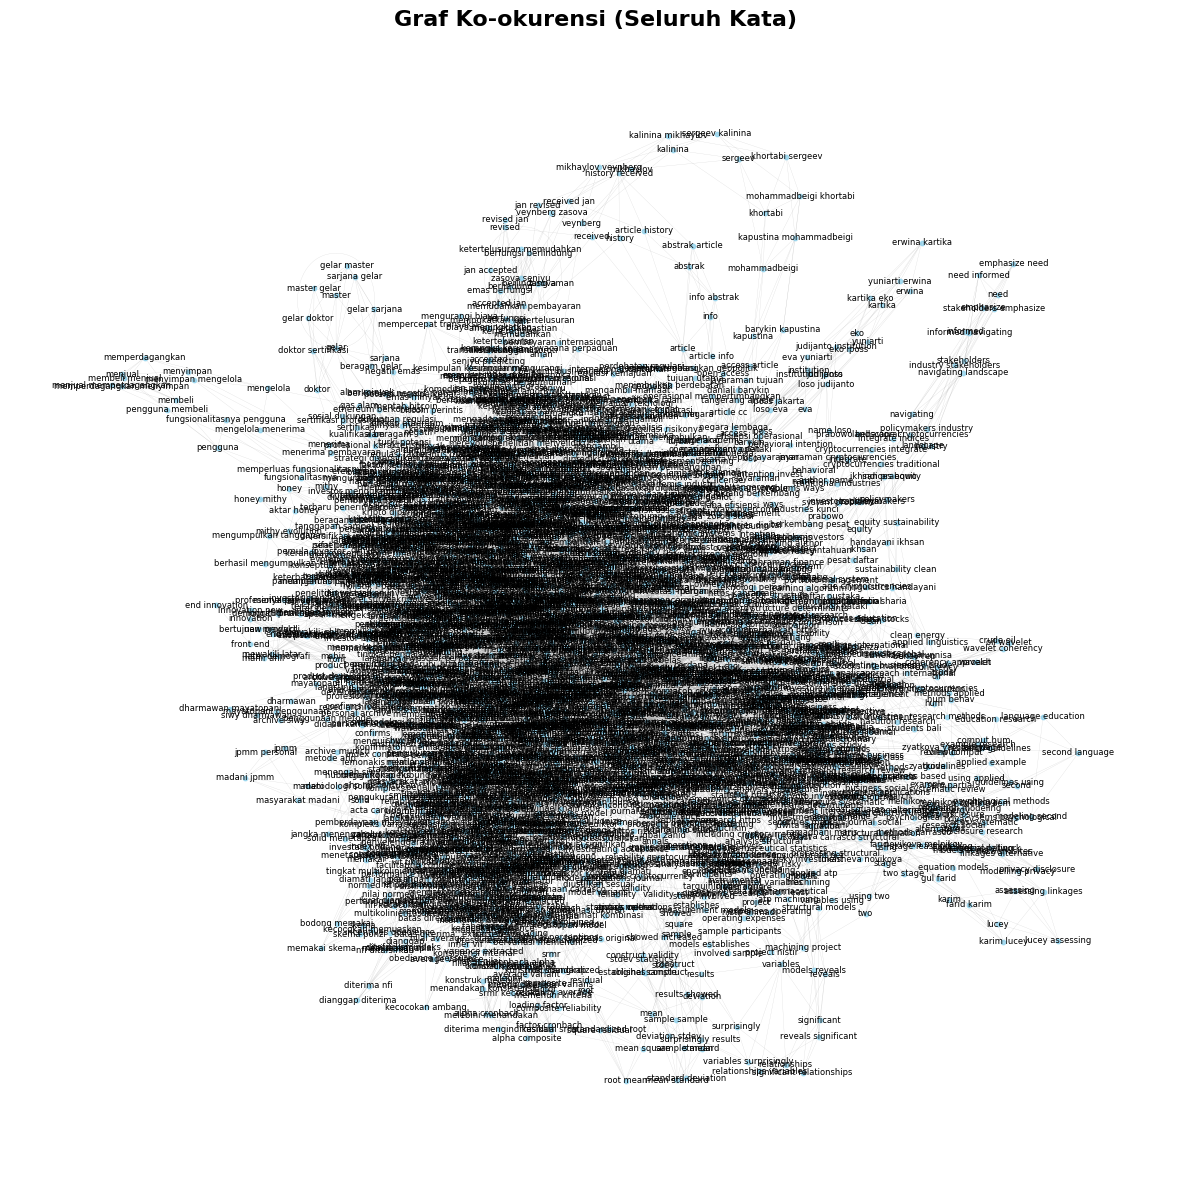

In [70]:
# Visualisasi graf ko-okurensi penuh
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
# Menghitung layout posisi node (dapat memakan waktu karena graf cukup besar)
pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)

# Gambar node dan edge
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, edge_color='gray')

# Tambahkan label kata pada setiap node (graf bisa menjadi cukup padat)
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=6)

plt.title("Graf Ko-okurensi (Seluruh Kata)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


## 6. Pembuatan Graf dari Matriks Ko-okurensi

Mengkonversi matriks ko-okurensi menjadi graf NetworkX di mana:
- **Node**: Kata-kata (unigram dan bigram)
- **Edge**: Hubungan ko-okurensi antar kata
- **Bobot**: Frekuensi kemunculan bersama

## 7. Seleksi 20 Kata Kunci Teratas

Menghitung PageRank pada **graf penuh** dan memilih 20 kata dengan nilai tertinggi. PageRank mengukur kepentingan kata berdasarkan struktur hubungan dengan kata-kata lain dalam jaringan.

In [71]:
# Hitung PageRank pada graf penuh dan pilih 20 node teratas
pagerank_full = nx.pagerank(G)
# Urutkan node berdasarkan PageRank (tertinggi ke terendah)
top_20_nodes = sorted(pagerank_full.items(), key=lambda item: item[1], reverse=True)[:20]

print("\n20 Kata Teratas Berdasarkan PageRank (Graf Penuh):")
for i, (node, pr) in enumerate(top_20_nodes, 1):
    print(f"{i}. {node}: {pr:.4f}")


20 Kata Teratas Berdasarkan PageRank (Graf Penuh):
1. mata uang: 0.0072
2. mata: 0.0071
3. uang kripto: 0.0068
4. kripto: 0.0067
5. uang: 0.0067
6. investasi: 0.0065
7. https: 0.0064
8. pasar: 0.0060
9. cryptocurrency: 0.0054
10. profitabilitas: 0.0050
11. penelitian: 0.0048
12. model: 0.0045
13. energi: 0.0045
14. keuangan: 0.0043
15. volatilitas: 0.0043
16. volatilitas pasar: 0.0040
17. indonesia: 0.0037
18. journal: 0.0037
19. et: 0.0033
20. investasi mata: 0.0032


In [72]:
# Buat subgraf dengan 20 node teratas
top_node_names = [node for node, _ in top_20_nodes]
# Ekstrak subgraf yang hanya berisi 20 node teratas
subgraph = G.subgraph(top_node_names)
print(f"\nSubgraf dibuat dengan {len(subgraph.nodes)} node dan {len(subgraph.edges)} edge.")


Subgraf dibuat dengan 20 node dan 79 edge.


## 8. Pembuatan Subgraf

Membuat subgraf yang hanya berisi 20 node teratas beserta koneksi antar mereka untuk analisis yang lebih fokus.

## 9. Perhitungan Semua Ukuran Sentralitas

Menghitung 4 ukuran sentralitas yang berbeda untuk mengidentifikasi kata kunci penting:

1. **PageRank**: Mengukur kepentingan kata berdasarkan struktur jaringan (kata yang terhubung ke kata penting lain)
2. **Degree Centrality**: Mengukur jumlah koneksi langsung yang dimiliki kata
3. **Betweenness Centrality**: Mengukur seberapa sering kata menjadi jembatan antara kata lain
4. **Closeness Centrality**: Mengukur kedekatan rata-rata kata ke semua kata lain dalam jaringan

In [73]:
# Hitung semua ukuran sentralitas
print("\nMenghitung ukuran sentralitas...")

# 1. PageRank - Mengukur kepentingan node berdasarkan struktur link
pagerank_values = nx.pagerank(subgraph)
pagerank_df = pd.DataFrame(list(pagerank_values.items()), columns=['Kata', 'PageRank'])
pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# 2. Degree Centrality - Mengukur jumlah koneksi langsung
degree_centrality_sub = nx.degree_centrality(subgraph)
degree_df = pd.DataFrame(list(degree_centrality_sub.items()), columns=['Kata', 'Degree_Centrality'])
degree_df = degree_df.sort_values(by='Degree_Centrality', ascending=False)

# 3. Betweenness Centrality - Mengukur seberapa sering node menjadi jembatan
betweenness_centrality = nx.betweenness_centrality(subgraph)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Kata', 'Betweenness_Centrality'])
betweenness_df = betweenness_df.sort_values(by='Betweenness_Centrality', ascending=False)

# 4. Closeness Centrality - Mengukur kedekatan node ke semua node lain
closeness_centrality = nx.closeness_centrality(subgraph)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Kata', 'Closeness_Centrality'])
closeness_df = closeness_df.sort_values(by='Closeness_Centrality', ascending=False)

print("Semua ukuran sentralitas berhasil dihitung.")


Menghitung ukuran sentralitas...
Semua ukuran sentralitas berhasil dihitung.


In [74]:
# Tampilkan hasil PageRank
print("\n" + "="*60)
print("PAGERANK CENTRALITY (Sentralitas PageRank)")
print("="*60)
print(pagerank_df.to_string(index=False))


PAGERANK CENTRALITY (Sentralitas PageRank)
             Kata  PageRank
             uang  0.108745
             mata  0.092994
           kripto  0.087512
      uang kripto  0.079080
        mata uang  0.074312
            pasar  0.072919
      volatilitas  0.071576
   profitabilitas  0.052936
        investasi  0.052026
   investasi mata  0.043138
volatilitas pasar  0.042577
           energi  0.034394
        indonesia  0.029758
   cryptocurrency  0.027785
               et  0.025926
       penelitian  0.023776
            https  0.023605
         keuangan  0.021635
          journal  0.018248
            model  0.017058


## 10. Hasil dan Visualisasi PageRank

PageRank menentukan kata kunci paling penting berdasarkan struktur jaringan. Kata dengan PageRank tinggi adalah kata yang terhubung dengan banyak kata penting lainnya.

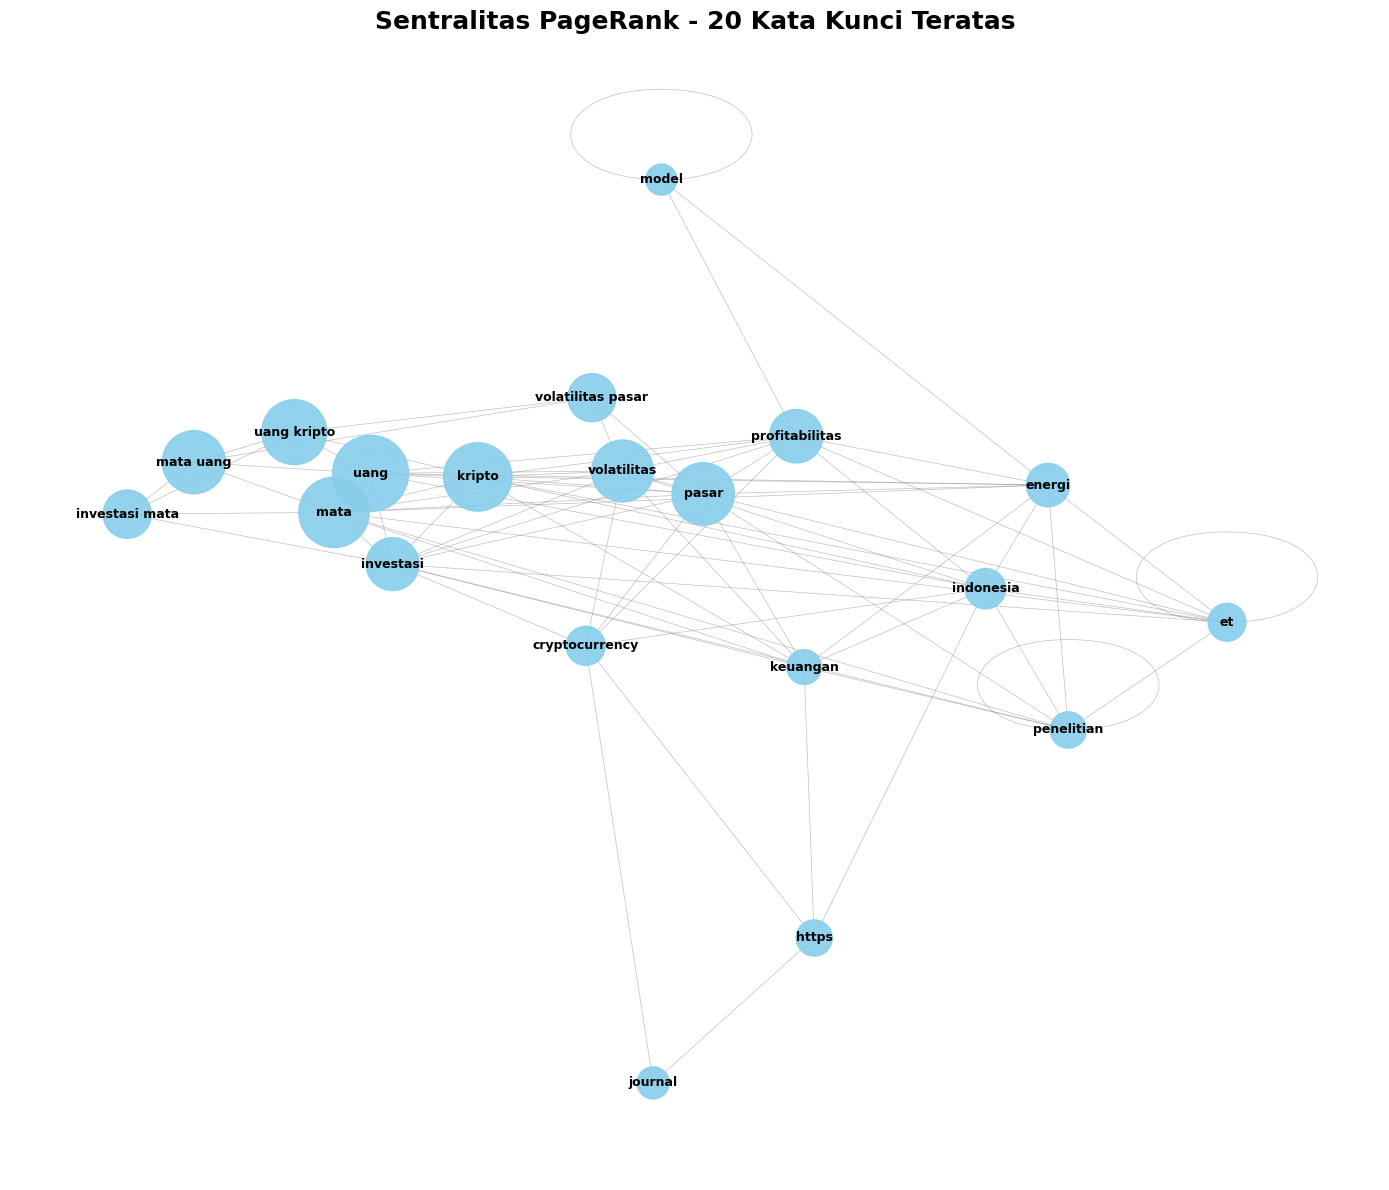

In [75]:
# Visualisasi PageRank
import matplotlib.pyplot as plt

# Buat figure dengan ukuran besar
plt.figure(figsize=(14, 12))
# Tentukan posisi node menggunakan spring layout
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan nilai PageRank
max_pr = max(pagerank_values.values())
min_pr = min(pagerank_values.values())
node_sizes = [500 + (v - min_pr) / (max_pr - min_pr) * 2500 if max_pr != min_pr else 1000 for v in pagerank_values.values()]

# Gambar node, edge, dan label
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas PageRank - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [76]:
# Tampilkan hasil Degree Centrality
print("\n" + "="*60)
print("DEGREE CENTRALITY (Sentralitas Derajat)")
print("="*60)
print(degree_df.to_string(index=False))


DEGREE CENTRALITY (Sentralitas Derajat)
             Kata  Degree_Centrality
            pasar           0.631579
        investasi           0.578947
             mata           0.578947
           kripto           0.578947
      volatilitas           0.526316
               et           0.526316
           energi           0.526316
   profitabilitas           0.526316
        indonesia           0.526316
             uang           0.526316
       penelitian           0.473684
         keuangan           0.473684
   cryptocurrency           0.368421
      uang kripto           0.263158
        mata uang           0.263158
volatilitas pasar           0.210526
            https           0.210526
   investasi mata           0.210526
            model           0.210526
          journal           0.105263


## 11. Hasil dan Visualisasi Degree Centrality

Degree Centrality mengidentifikasi kata yang memiliki koneksi terbanyak dengan kata lain. Semakin tinggi nilai degree centrality, semakin banyak kata yang berhubungan dengannya.

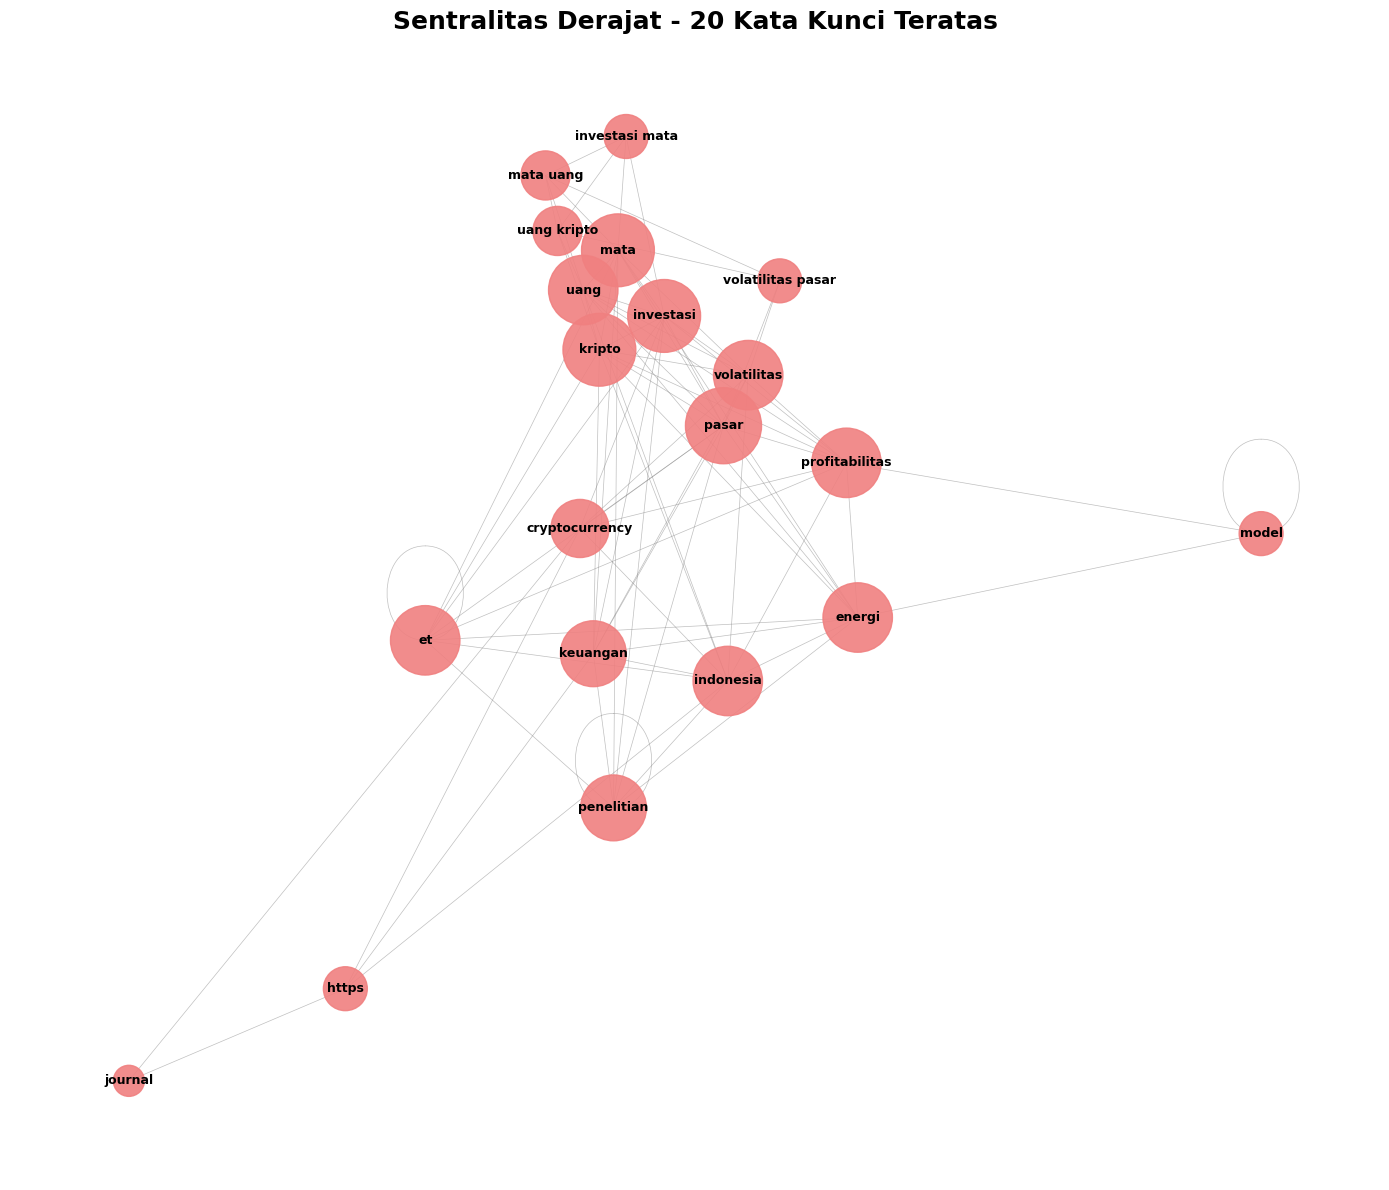

In [77]:
# Visualisasi Degree Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan degree centrality
max_deg = max(degree_centrality_sub.values())
min_deg = min(degree_centrality_sub.values())
node_sizes = [500 + (v - min_deg) / (max_deg - min_deg) * 2500 if max_deg != min_deg else 1000 for v in degree_centrality_sub.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Derajat - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [78]:
# Tampilkan hasil Betweenness Centrality
print("\n" + "="*60)
print("BETWEENNESS CENTRALITY (Sentralitas Keantaraan)")
print("="*60)
print(betweenness_df.to_string(index=False))


BETWEENNESS CENTRALITY (Sentralitas Keantaraan)
             Kata  Betweenness_Centrality
   cryptocurrency                0.096869
            pasar                0.079050
             mata                0.077243
        investasi                0.075600
   profitabilitas                0.070226
        indonesia                0.069924
             uang                0.067739
           energi                0.056816
           kripto                0.052015
      volatilitas                0.050919
         keuangan                0.047245
            https                0.021893
      uang kripto                0.012346
volatilitas pasar                0.011756
        mata uang                0.009950
   investasi mata                0.007888
               et                0.006803
       penelitian                0.004432
          journal                0.000000
            model                0.000000


## 12. Hasil dan Visualisasi Betweenness Centrality

Betweenness Centrality mengidentifikasi kata yang berperan sebagai jembatan dalam jaringan. Kata dengan nilai tinggi menghubungkan kelompok kata yang berbeda.

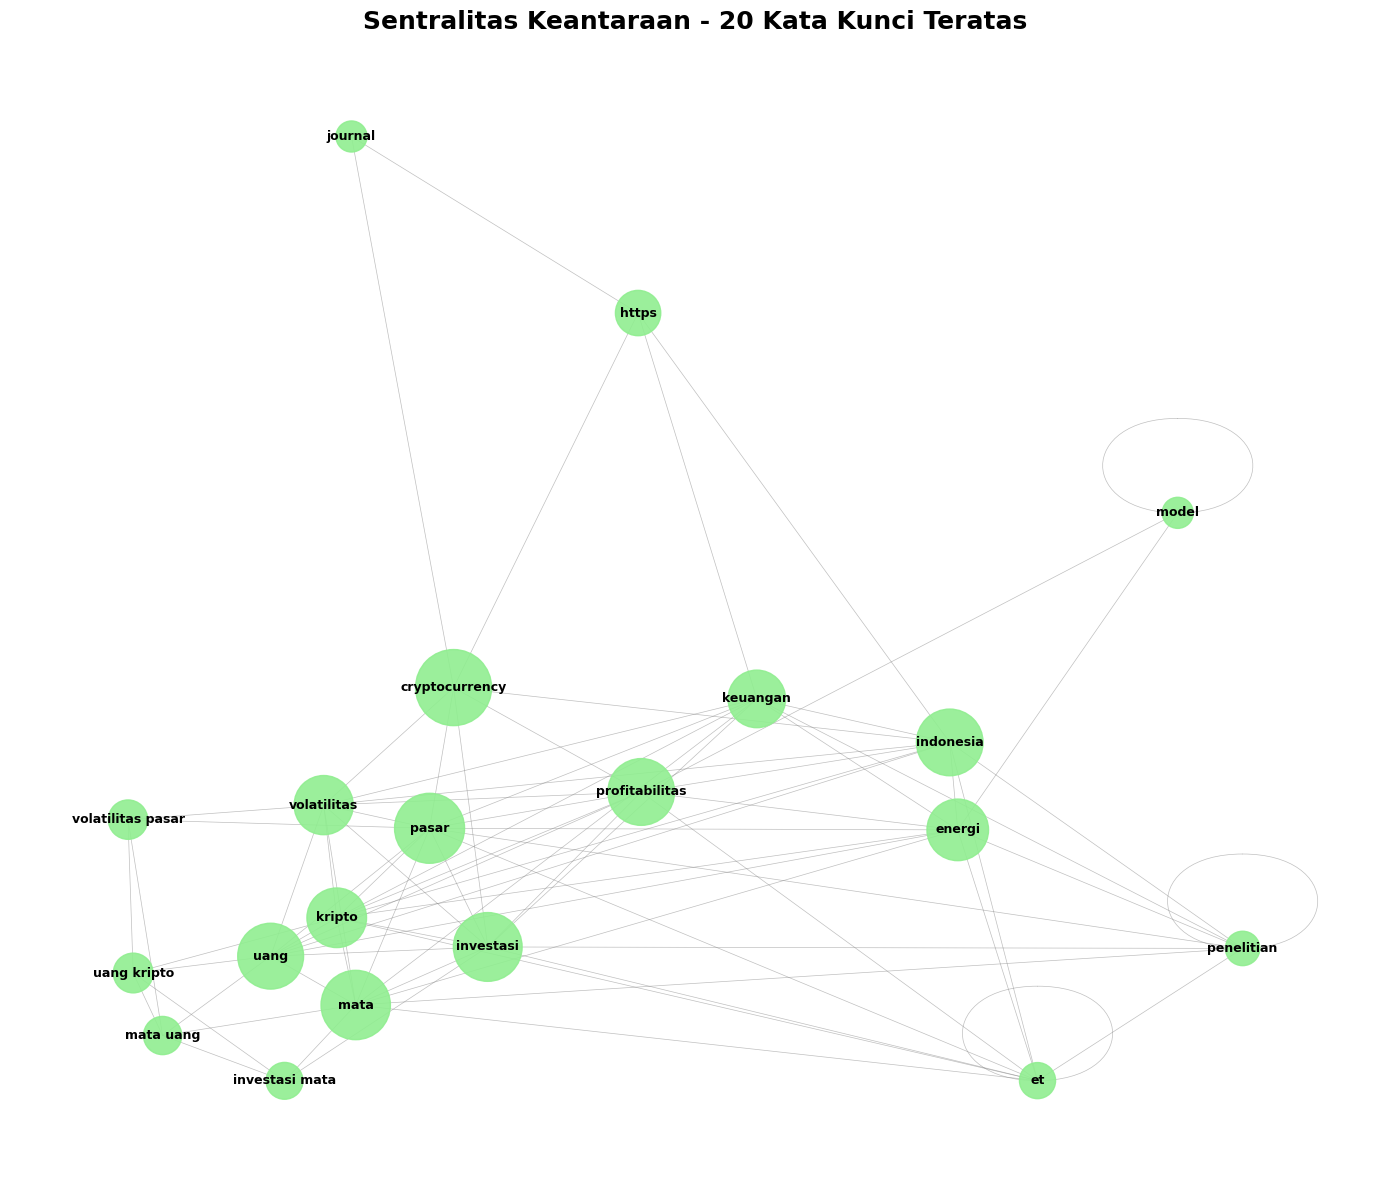

In [79]:
# Visualisasi Betweenness Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan betweenness centrality
max_btw = max(betweenness_centrality.values())
min_btw = min(betweenness_centrality.values())
node_sizes = [500 + (v - min_btw) / (max_btw - min_btw) * 2500 if max_btw != min_btw else 1000 for v in betweenness_centrality.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightgreen', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Keantaraan - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [80]:
# Tampilkan hasil Closeness Centrality
print("\n" + "="*60)
print("CLOSENESS CENTRALITY (Sentralitas Kedekatan)")
print("="*60)
print(closeness_df.to_string(index=False))


CLOSENESS CENTRALITY (Sentralitas Kedekatan)
             Kata  Closeness_Centrality
            pasar              0.730769
        investasi              0.703704
      volatilitas              0.678571
             mata              0.678571
   profitabilitas              0.678571
           kripto              0.678571
         keuangan              0.655172
           energi              0.655172
             uang              0.655172
        indonesia              0.655172
               et              0.612903
   cryptocurrency              0.575758
       penelitian              0.575758
volatilitas pasar              0.513514
        mata uang              0.500000
   investasi mata              0.500000
      uang kripto              0.487179
            https              0.487179
            model              0.452381
          journal              0.387755


## 13. Hasil dan Visualisasi Closeness Centrality

Closeness Centrality mengukur seberapa dekat sebuah kata dengan semua kata lainnya. Kata dengan nilai tinggi dapat dengan cepat terhubung ke kata lain dalam jaringan.

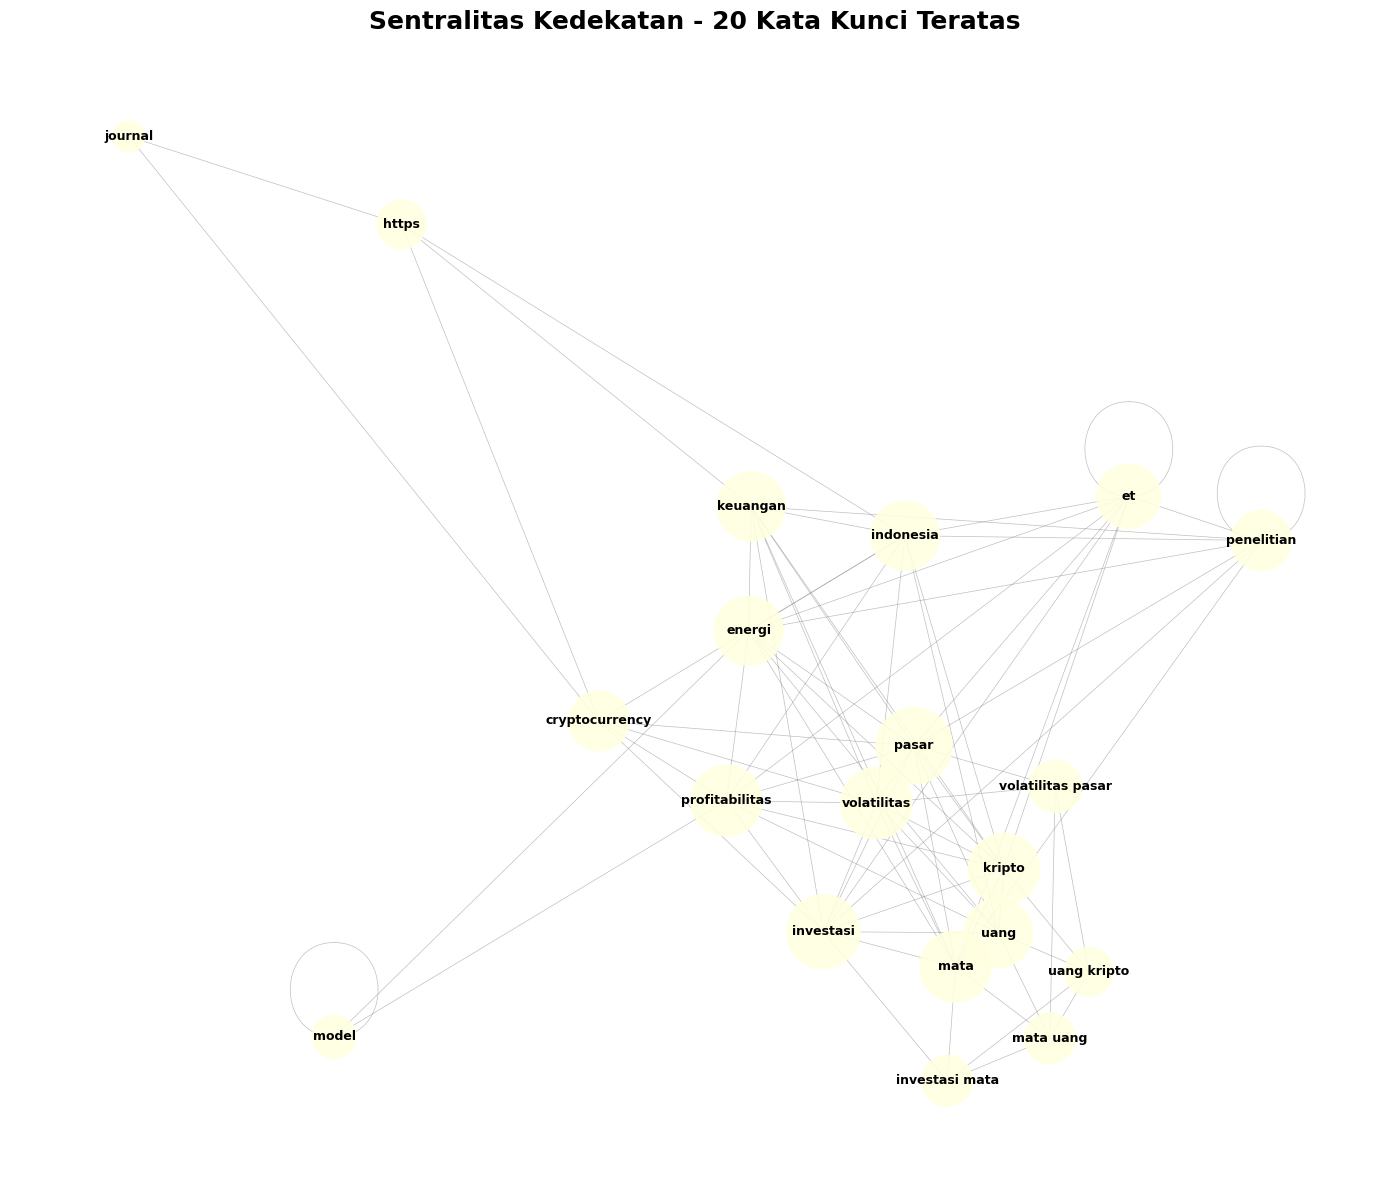

In [81]:
# Visualisasi Closeness Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan closeness centrality
max_clo = max(closeness_centrality.values())
min_clo = min(closeness_centrality.values())
node_sizes = [500 + (v - min_clo) / (max_clo - min_clo) * 2500 if max_clo != min_clo else 1000 for v in closeness_centrality.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightyellow', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Kedekatan - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [82]:
# Ringkasan: Semua Ukuran Sentralitas Digabungkan
summary_df = pd.DataFrame({
    'Kata': pagerank_df['Kata'],
    'PageRank': pagerank_df['PageRank'].values,
    'Degree': [degree_centrality_sub[node] for node in pagerank_df['Kata']],
    'Betweenness': [betweenness_centrality[node] for node in pagerank_df['Kata']],
    'Closeness': [closeness_centrality[node] for node in pagerank_df['Kata']]
})

print("\n" + "="*90)
print("RINGKASAN: SEMUA UKURAN SENTRALITAS UNTUK 20 KATA KUNCI TERATAS")
print("="*90)
print(summary_df.to_string(index=False))

# Simpan hasil ke file CSV
summary_df.to_csv('hasil_ekstraksi_kata_kunci.csv', index=False)
print("\nHasil disimpan ke 'hasil_ekstraksi_kata_kunci.csv'")


RINGKASAN: SEMUA UKURAN SENTRALITAS UNTUK 20 KATA KUNCI TERATAS
             Kata  PageRank   Degree  Betweenness  Closeness
             uang  0.108745 0.526316     0.067739   0.655172
             mata  0.092994 0.578947     0.077243   0.678571
           kripto  0.087512 0.578947     0.052015   0.678571
      uang kripto  0.079080 0.263158     0.012346   0.487179
        mata uang  0.074312 0.263158     0.009950   0.500000
            pasar  0.072919 0.631579     0.079050   0.730769
      volatilitas  0.071576 0.526316     0.050919   0.678571
   profitabilitas  0.052936 0.526316     0.070226   0.678571
        investasi  0.052026 0.578947     0.075600   0.703704
   investasi mata  0.043138 0.210526     0.007888   0.500000
volatilitas pasar  0.042577 0.210526     0.011756   0.513514
           energi  0.034394 0.526316     0.056816   0.655172
        indonesia  0.029758 0.526316     0.069924   0.655172
   cryptocurrency  0.027785 0.368421     0.096869   0.575758
               et  0

## 14. Ringkasan Hasil

Menampilkan tabel ringkasan yang menggabungkan semua ukuran sentralitas untuk 20 kata kunci teratas. Tabel ini memudahkan perbandingan antar metrik dan menyimpan hasilnya ke file CSV.